In [1]:
############################
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import seaborn as sns

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt # For plotting
import numpy as np              # For working with numerical data
import sklearn.cluster as sklc  # For clustering
import sklearn.metrics as sklm  # For the silhouette score

from pygam import GAM, s, f
from pygam import LinearGAM
from statsmodels.gam.api import GLMGam, BSplines
from statsmodels.formula.api import ols
from statsmodels.nonparametric.smoothers_lowess import lowess

plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

#############################
data_filename = pd.read_csv('data2.csv')
df = pd.DataFrame(data_filename)


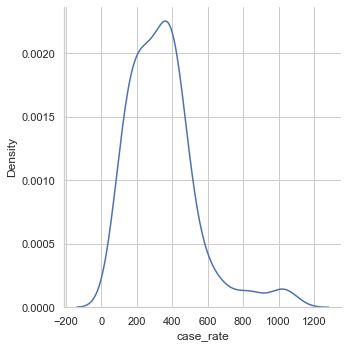

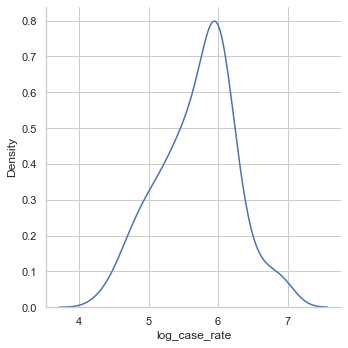

In [2]:
# Let us check the distribution of the observations (COVID-19 case rate in local authority area i of England) we investigate
sns.displot(df, x = 'case_rate', kind="kde")
plt.savefig('case_rate')

# As the plot is heavily right-tailed (positively skewed), we apply a log-linear model in the analysis where the new dependent variable 
# is the natural logarithm of the observations of COVID-19 case rate in local authority area i of England

sns.displot(df, x = 'log_case_rate', kind="kde")
plt.savefig('log_case_rate')
# The second plot looks more similar to normal distirbution.

In [3]:
# Check the outliers of the observations (COVID-19 case rate in local authority area i of England in month j)
case_rate= np.log(df['case_rate'])
Q1 =  case_rate.quantile(0.25)
Q3 = case_rate.quantile(0.75)
IQR = Q3 - Q1


case_rate_outliers = df['Lower Tier Local Authority'][(np.log(df['case_rate']) < Q1-1.5*IQR ) | (np.log(df['case_rate']) > Q3+1.5*IQR)]

case_rate_no_outliers = df['Lower Tier Local Authority'][(np.log(df['case_rate']) > Q1-1.5*IQR ) | (np.log(df['case_rate']) < Q3+1.5*IQR)]

case_rate_outliers

Series([], Name: case_rate, dtype: float64)

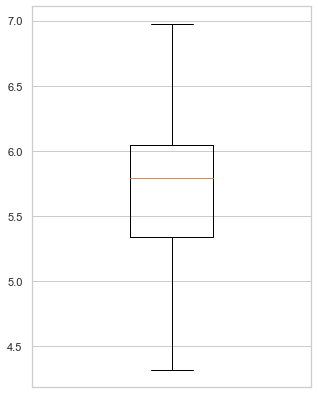

In [4]:
# And draw the boxplot to visualize the distribution of 'np.log(df['case_rate'])':
output_filename = 'boxplot'
figure_width, figure_height = 5,7
plt.figure(figsize=(figure_width,figure_height))
plt.xlim([0.75,1.25])
plt.xticks([])
plt.boxplot(df['case_rate'], manage_ticks=(False))
plt.savefig(output_filename)

In [9]:
# Create dummy variables for time and region variables
Month = pd.get_dummies(df['month'])
Month = Month[['November','December']]

Region = pd.get_dummies(df['region'])
Region = Region[['East of England','North East', 'North West', 'South East', 'South West', 'East Midlands', 'West Midlands','Yorkshire and the Humber']]
# Create the variables for climate features: 'precipitation','humidity' and 'temp'
x_values = df[['precipitation','humidity','temperature']]

# Combine the variables for climate features with dummy variables for time and region variables
x_values = pd.concat([x_values, Month, Region], axis=1, sort=False)

# Create the dependent variable
y_values = np.log(df['case_rate'])

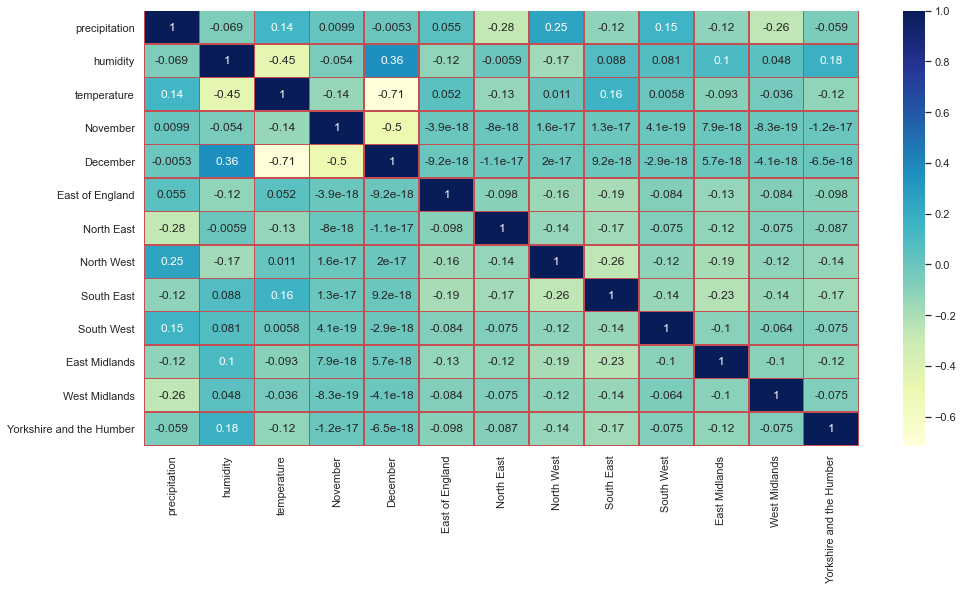

In [6]:
# Let us firstly check the correlation between independent variables (e.g. create a heat map)
fig = plt.figure(figsize=(16,8))
sns.heatmap(x_values.corr(),annot = True,cmap='YlGnBu', linecolor='r',linewidth=0.5)
output_filename = 'correlation matrix'
plt.savefig(output_filename)

                            OLS Regression Results                            
Dep. Variable:          log_case_rate   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     6.141
Date:                Mon, 18 Jan 2021   Prob (F-statistic):           1.47e-08
Time:                        18:45:06   Log-Likelihood:                -89.488
No. Observations:                 150   AIC:                             205.0
Df Residuals:                     137   BIC:                             244.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

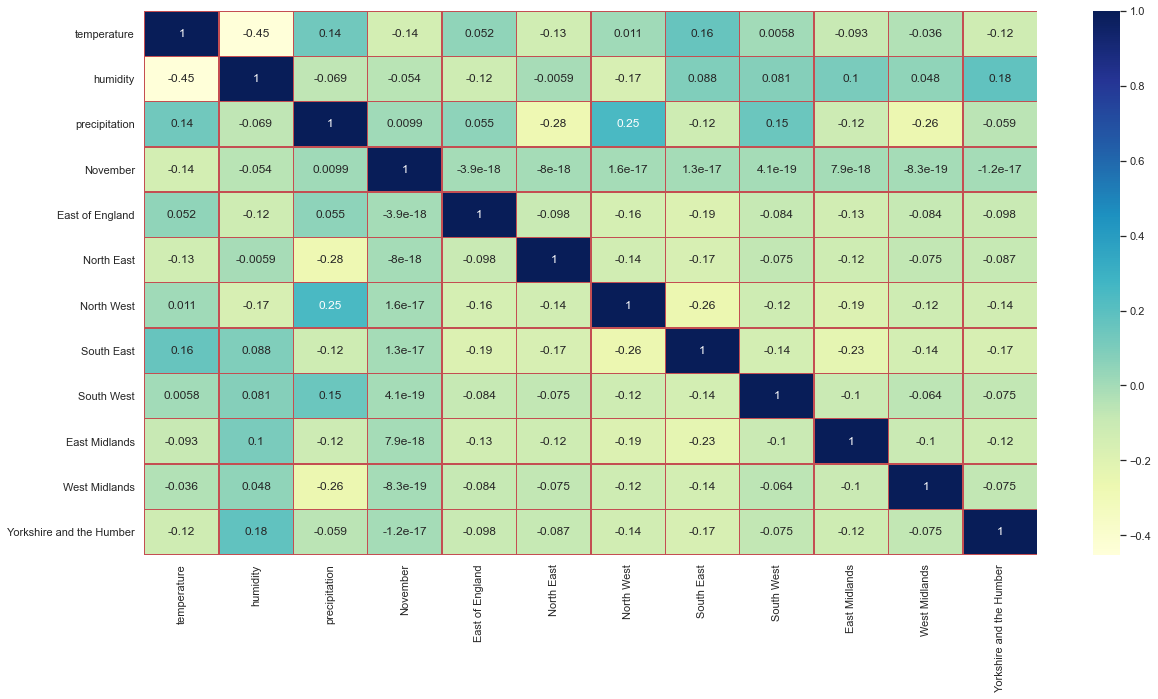

In [7]:
# As the correlations between the dummy variable 'December' and the variable of temperature is larger than 0.07,
# we cannot assume that multicollinearity doesn't exist.
# Hence, we remove the dummy variable 'December' from the model.

# Create dummy variables for time and region variables and remove variables for 'December'
Month = pd.get_dummies(df['month'])
Month = Month['November']

Region = pd.get_dummies(df['region'])
Region = Region[['East of England','North East','North West','South East','South West','East Midlands','West Midlands','Yorkshire and the Humber']]

# df['humidity:temp'] = df['humidity']*df['temp']

# df['November:East Midlands'] = Month*Region['East Midlands']
x_values = df[['temperature', 'humidity','precipitation']]
x_values = pd.concat([x_values, Month, Region], axis=1, sort=False)

# Create the dependent variable
y_values = df['log_case_rate']

fig = plt.figure(figsize=(20,10))
sns.heatmap(x_values.corr(),annot = True,cmap='YlGnBu', linecolor='r',linewidth=0.5)

X_values = sms.add_constant(x_values)
regression_model_a = sms.OLS(y_values, X_values)

regression_model_b = regression_model_a.fit()

# Print a summary of the results:
print(regression_model_b.summary())
# As the p value of precipitation is larger than 0.05, we cannot reject the null hypothesis and remove precipitation from the model.

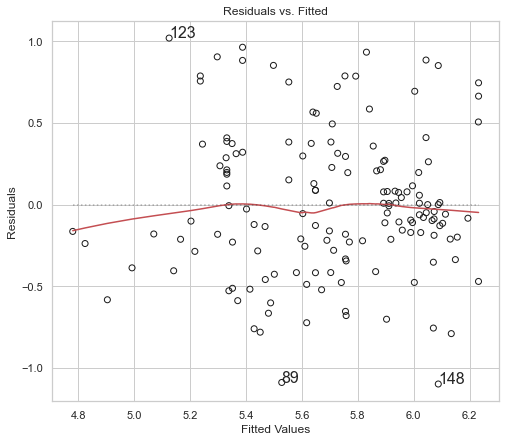

In [8]:
# Check the model fitness by residuals vs fitted plot:
residuals = regression_model_b.resid
fitted = regression_model_b.fittedvalues
smoothed = lowess(residuals,fitted)
top3 = abs(residuals).sort_values(ascending = False)[:3]

plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (8,7)
fig, ax = plt.subplots()
ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted Values')
ax.set_title('Residuals vs. Fitted')
ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

for i in top3.index:
    ax.annotate(i,xy=(fitted[i],residuals[i]))

plt.show()
